In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3  # Using InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Path to the dataset
dataset_dir = '/content/drive/MyDrive/Soil Nitrogen Levels'

# Create lists to hold image paths and labels
image_paths = []
labels = []

# Walk through each class directory
for label in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(label)

# Convert the data into a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Split the dataset (80% train, 10% validation, 10% test)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)


In [ ]:
# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    brightness_range=[0.8, 1.2],
    channel_shift_range=30
)


# Validation and test data generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=(299, 299),  # InceptionV3 requires input size of 299x299
    batch_size=32,
    class_mode='categorical'
)

# Load validation data from DataFrame
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load testing data from DataFrame
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='image_path',
    y_col='label',
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 608 validated image filenames belonging to 4 classes.
Found 76 validated image filenames belonging to 4 classes.
Found 76 validated image filenames belonging to 4 classes.


In [ ]:
# Split the dataset (80% for training, 10% for validation, 10% for testing)
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Save the split dataset to CSV files (optional)
train_data.to_csv('/content/drive/MyDrive/mareertrain_datainv_80.csv', index=False)
val_data.to_csv('/content/drive/MyDrive/mareerval_datainc_10.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/mareertest_datainc_10.csv', index=False)

# Display the shapes of training, validation, and testing sets
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Testing set: {test_data.shape}")


Training set: (608, 2)
Validation set: (76, 2)
Testing set: (76, 2)


In [ ]:
# Load the InceptionV3 model, excluding the top fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional base of InceptionV3 to prevent training initially
for layer in base_model.layers:
    layer.trainable = False


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use global average pooling instead of Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer with softmax activation for multi-class classification
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Unfreeze the last few layers of InceptionV3 for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreezing the last 20 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Add callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_inceptionv3_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 544s 17s/step - accuracy: 0.3084 - loss: 1.5045 - val_accuracy: 0.5938 - val_loss: 1.1211
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 929ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 1.0753
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step - accuracy: 0.5201 - loss: 1.0817 - val_accuracy: 0.5156 - val_loss: 1.0213
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5833 - val_loss: 1.0043
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.5486 - loss: 0.9789 - val_accuracy: 0.5312 - val_loss: 0.9408
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.9202
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 192s 6s/step - accuracy: 0.5960 - loss: 0.8824 - val_accuracy: 0.5469 - val_loss: 0.8879
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.8781
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.6149 - loss: 0.8713 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.6771 - loss: 0.7331
Test Loss: 0.7637121677398682, Test Accuracy: 0.640625


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step


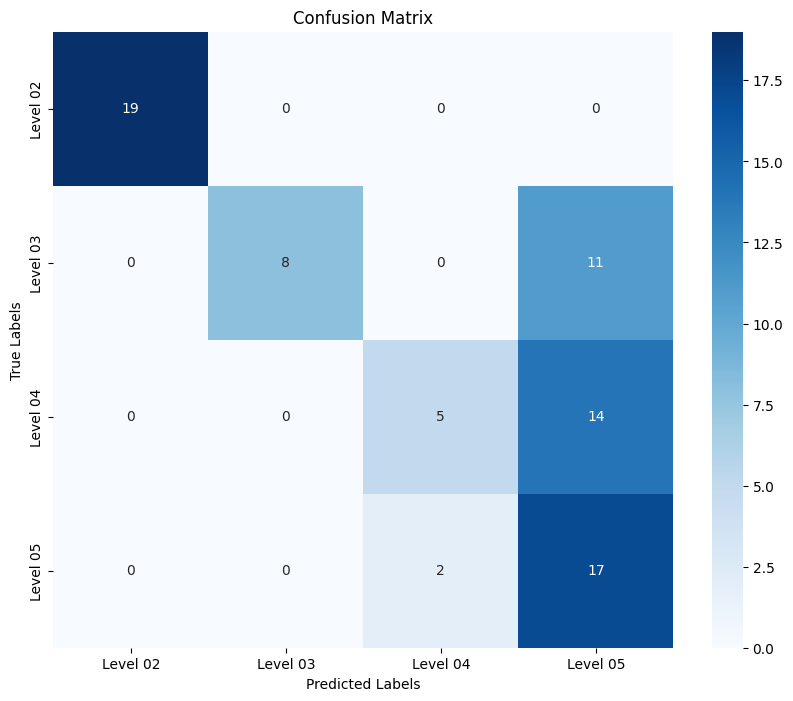

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test generator
true_labels = test_generator.classes

# Predict the probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the class labels (for use in confusion matrix)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


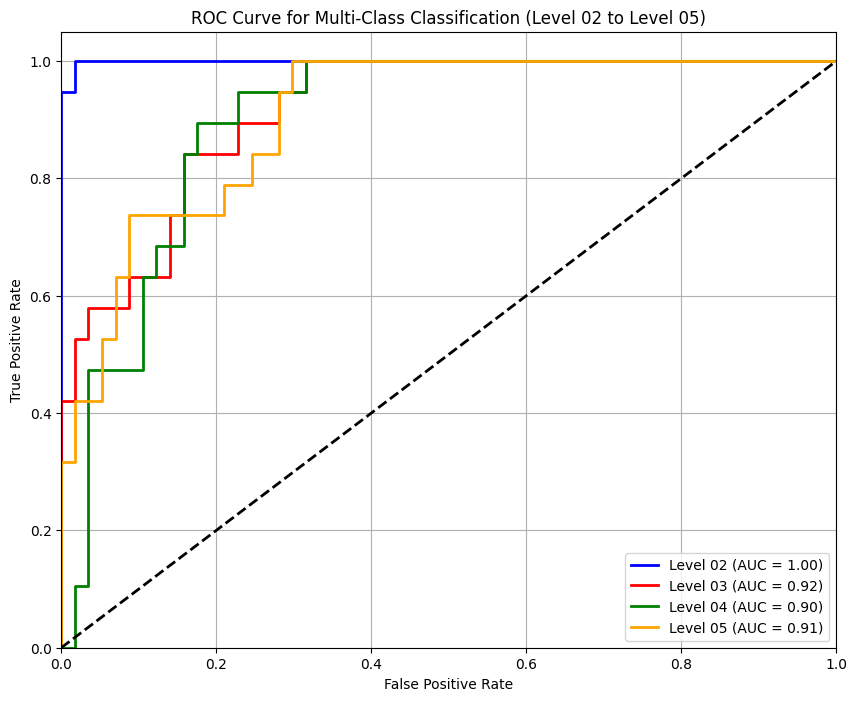

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Define the class labels (for use in plotting and binarization)
class_labels = ['Level 02', 'Level 03', 'Level 04', 'Level 05']

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(class_labels)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()  # AUC for each class

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification (Level 02 to Level 05)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the input layer with shape (299, 299, 3) for InceptionV3
input_layer = Input(shape=(299, 299, 3))

# Load the InceptionV3 model with pre-trained weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze the InceptionV3 base layers to prevent them from being trained initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensionality
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # First dense layer with L2 regularization
x = Dropout(0.5)(x)  # Dropout for additional regularization
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)  # Second dense layer with L2 regularization
x = Dropout(0.5)(x)

# Output layer with softmax for multi-class classification (e.g., 10 classes)
output_layer = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Save the trained model in the .keras format (recommended for new Keras versions)
model.save('/content/drive/MyDrive/resfinal_trained_model.keras')


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Get true labels and predict probabilities
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Binarize the true labels for multi-class classification (one-vs-rest)
n_classes = len(test_generator.class_indices)
true_labels_bin = label_binarize(true_labels, classes=list(range(n_classes)))

# Calculate macro and weighted AUC
macro_auc = roc_auc_score(true_labels_bin, predictions, average='macro', multi_class='ovr')
weighted_auc = roc_auc_score(true_labels_bin, predictions, average='weighted', multi_class='ovr')

# Print the results
print(f"Macro AUC: {macro_auc:.4f}")
print(f"Weighted AUC: {weighted_auc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step
Macro AUC: 0.9305
Weighted AUC: 0.9305


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Get true labels from test generator
true_labels = test_generator.classes

# Predict probabilities on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Display the classification report
print(report)

# Calculate the macro and weighted F1-scores
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
weighted_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the macro and weighted F1-scores
print(f"Macro F1-Score: {macro_f1}")
print(f"Weighted F1-Score: {weighted_f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
              precision    recall  f1-score   support

    Level 02       1.00      1.00      1.00        19
    Level 03       1.00      0.42      0.59        19
    Level 04       0.71      0.26      0.38        19
    Level 05       0.40      0.89      0.56        19

    accuracy                           0.64        76
   macro avg       0.78      0.64      0.63        76
weighted avg       0.78      0.64      0.63        76

Macro F1-Score: 0.6336462565970762
Weighted F1-Score: 0.6336462565970763
